# Testing note segmentation
Or is it called note estimation?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scripts.midi.MidiLoader import MidiLoader
from scripts.midi.MidiSynth import MidiSynth
from scripts.midi.MidiPlayer import MidiPlayer
from scripts.audio.AudioPlayer import AudioPlayer

from scripts.dtw.MidiDTW import MidiDTW, CQTFeatures

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# Play the template audio
audio_player = AudioPlayer()

# Play a given audio file
AUDIO_FILEPATH = 'data/audio_files/user_fugue.mp3'
audio_player.load_audio(AUDIO_FILEPATH)
audio_player.play()

## Attempt 1: With onset detection

In [6]:
from essentia.standard import *
import essentia
import numpy as np
import IPython

AUDIO_FILEPATH = 'data/audio_files/user_fugue.mp3'

user_audio = MonoLoader(filename=AUDIO_FILEPATH)()

od_hfc = OnsetDetection(method='hfc')
od_complex = OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(user_audio, frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.hfc', od_hfc(magnitude, phase))
    pool.add('odf.complex', od_complex(magnitude, phase))

# 2. Detect onset locations.
onsets = Onsets()

onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                    essentia.array([pool['odf.hfc']]),
                    # You need to specify weights, but if we use only one ODF
                    # it doesn't actually matter which weight to give it
                    [1])

onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])


# Add onset markers to the audio and save it to a file.
# We use beeps instead of white noise and stereo signal as it's more distinctive.

# We want to keep beeps in a separate audio channel.
# Add them to a silent audio and use the original audio as another channel. Mux both into a stereo signal.
silence = [0.] * len(user_audio)

beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)

audio_hfc = StereoMuxer()(user_audio, beeps_hfc)
audio_complex = StereoMuxer()(user_audio, beeps_complex)

# Save the audio to a file.
import soundfile as sf

sf.write('data/audio_files/user_fugue_hfc.wav', audio_hfc, 44100)
sf.write('data/audio_files/user_fugue_complex.wav', audio_complex, 44100)

### Listen to the two results...
Not good.

- HFC underperforms
- Complex is better but tends to over-segment and still misses some note changes

In [8]:
IPython.display.Audio('data/audio_files/user_fugue_hfc.wav')

In [9]:
IPython.display.Audio('data/audio_files/user_fugue_complex.wav')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy
n_frames = len(pool['odf.hfc'])
frames_position_samples = numpy.array(range(n_frames)) * 512

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15, 16))

ax1.set_title('HFC ODF')
ax1.plot(frames_position_samples, pool['odf.hfc'], color='magenta')

ax2.set_title('Complex ODF')
ax2.plot(frames_position_samples, pool['odf.complex'], color='red')

ax3.set_title('Audio waveform and the estimated onset positions (HFC ODF)')
ax3.plot(user_audio)
for onset in onsets_hfc:
    ax3.axvline(x=onset*44100, color='magenta')

ax4.set_title('Audio waveform and the estimated onset positions (complex ODF)')
ax4.plot(user_audio)
for onset in onsets_complex:
    ax4.axvline(x=onset*44100, color='red')

## Attempt 2: PitchMelodia

Not bad, but why is confidence so low? And also not super precise, it smooths out the pitch inaccuracies a little too much, maybe.

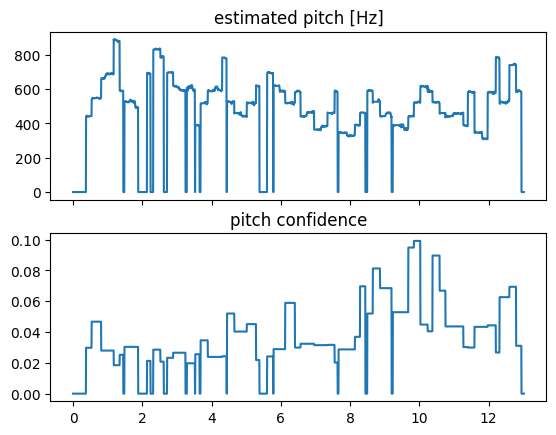

In [16]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt

AUDIO_FILEPATH = 'data/audio_files/user_fugue.mp3'

# Load audio file with equal-loudness filter
user_audio = es.MonoLoader(filename=AUDIO_FILEPATH, sampleRate=44100)()
user_audio = es.EqualLoudness()(user_audio)

# Extract pitch curve
# pitch_extractor = es.PredominantPitchMelodia(frameSize=2048, hopSize=128)

FRAME_SIZE = 2048
HOP_SIZE = 128
MIN_VIOLIN_FREQ = 196.0
MAX_VIOLIN_FREQ = 4700.0
SAMPLE_RATE = 44100

pitch_melodia = es.PitchMelodia(
    frameSize=FRAME_SIZE, 
    hopSize=HOP_SIZE,
    # guessUnvoiced=True,
    minFrequency=MIN_VIOLIN_FREQ,
    maxFrequency=MAX_VIOLIN_FREQ,
    sampleRate=SAMPLE_RATE
)
pitch_values, pitch_confidences = pitch_melodia(user_audio)

# Pitch is estimated on frames. Compute frame time positions.
pitch_times = np.linspace(0.0, len(user_audio)/SAMPLE_RATE, len(pitch_values))

# Plot the estimated pitch contour and confidence over time.
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(pitch_times, pitch_values)
axarr[0].set_title('estimated pitch [Hz]')
axarr[1].plot(pitch_times, pitch_confidences)
axarr[1].set_title('pitch confidence')
plt.show()

In [14]:
from mir_eval.sonify import pitch_contour

# synthesized_melody = pitch_contour(pitch_times, pitch_values, 44100)[:len(user_audio)]

for pitch, time in zip(pitch_values, pitch_times):
    print(f'{time:.2f} {pitch:.2f}')

# Save the audio to a file.
import soundfile as sf

sf.write('data/audio_files/user_fugue_pitchmelodia.wav', synthesized_melody, 44100)

0.00 0.00
0.00 0.00
0.01 0.00
0.01 0.00
0.01 0.00
0.01 0.00
0.02 0.00
0.02 0.00
0.02 0.00
0.03 0.00
0.03 0.00
0.03 0.00
0.03 0.00
0.04 0.00
0.04 0.00
0.04 0.00
0.05 0.00
0.05 0.00
0.05 0.00
0.06 0.00
0.06 0.00
0.06 0.00
0.06 0.00
0.07 0.00
0.07 0.00
0.07 0.00
0.08 0.00
0.08 0.00
0.08 0.00
0.08 0.00
0.09 0.00
0.09 0.00
0.09 0.00
0.10 0.00
0.10 0.00
0.10 0.00
0.10 0.00
0.11 0.00
0.11 0.00
0.11 0.00
0.12 0.00
0.12 0.00
0.12 0.00
0.12 0.00
0.13 0.00
0.13 0.00
0.13 0.00
0.14 0.00
0.14 0.00
0.14 0.00
0.15 0.00
0.15 0.00
0.15 0.00
0.15 0.00
0.16 0.00
0.16 0.00
0.16 0.00
0.17 0.00
0.17 0.00
0.17 0.00
0.17 0.00
0.18 0.00
0.18 0.00
0.18 0.00
0.19 0.00
0.19 0.00
0.19 0.00
0.19 0.00
0.20 0.00
0.20 0.00
0.20 0.00
0.21 0.00
0.21 0.00
0.21 0.00
0.21 0.00
0.22 0.00
0.22 0.00
0.22 0.00
0.23 0.00
0.23 0.00
0.23 0.00
0.24 0.00
0.24 0.00
0.24 0.00
0.24 0.00
0.25 0.00
0.25 0.00
0.25 0.00
0.26 0.00
0.26 0.00
0.26 0.00
0.26 0.00
0.27 0.00
0.27 0.00
0.27 0.00
0.28 0.00
0.28 0.00
0.28 0.00
0.28 0.00
0.29 0.00


In [14]:
IPython.display.Audio('data/audio_files/user_fugue.mp3')

In [12]:
IPython.display.Audio('data/audio_files/user_fugue_pitchmelodia.wav')

## Attempt 3: Individual pitch detection

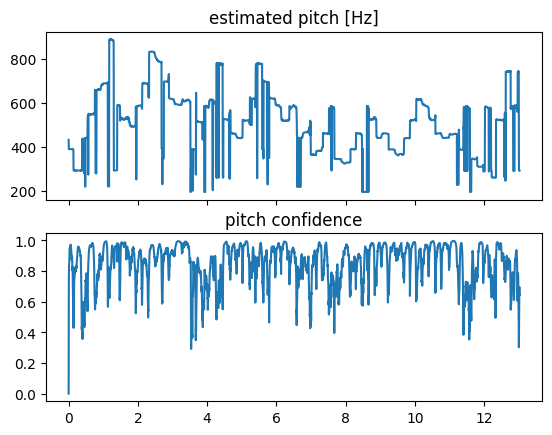

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import essentia.standard as es
import numpy as np

# Load audio file with equal-loudness filter
AUDIO_FILEPATH = 'data/audio_files/user_fugue.mp3'

user_audio = es.MonoLoader(filename=AUDIO_FILEPATH, sampleRate=44100)()
user_audio = es.EqualLoudness()(user_audio)

FRAME_SIZE = 2048
MIN_VIOLIN_FREQ = 196.0
MAX_VIOLIN_FREQ = 4700.0

pitchYin = es.PitchYin(
    frameSize=FRAME_SIZE,
    interpolate=True,
    maxFrequency=MAX_VIOLIN_FREQ,
    minFrequency=MIN_VIOLIN_FREQ,
    sampleRate=44100,
    tolerance=0.15
)

pitch_values = []
pitch_confidences = []
notes = []

for frame in es.FrameGenerator(user_audio, frameSize=FRAME_SIZE, hopSize=128):
    # FLOAT32_RANGE = 32768.0
    # frame = frame.astype(np.float32) / FLOAT32_RANGE
    pitch, confidence = pitchYin(frame)
    pitch_values.append(pitch)
    pitch_confidences.append(confidence)

# Pitch is estimated on frames. Compute frame time positions.
pitch_times = np.linspace(0.0,len(user_audio)/44100.0,len(pitch_values) )

# Plot the estimated pitch contour and confidence over time.
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(pitch_times, pitch_values)
axarr[0].set_title('estimated pitch [Hz]')
axarr[1].plot(pitch_times, pitch_confidences)
axarr[1].set_title('pitch confidence')
plt.show()

## The Hann window

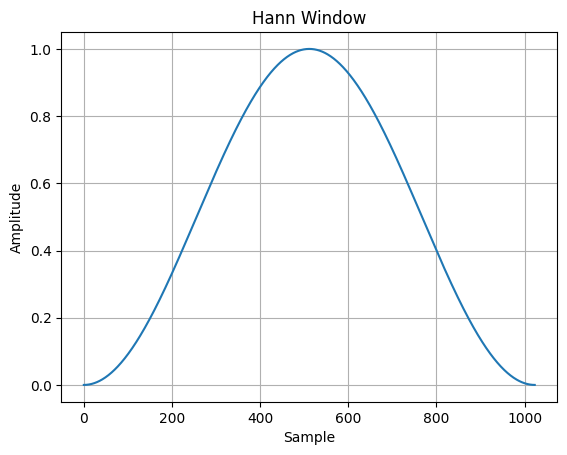

In [18]:
import numpy as np
import matplotlib.pyplot as plt

WINDOW_SIZE = 1024 # Number of samples in the window
n = np.arange(WINDOW_SIZE)
hann_window = 0.5 * (1 - np.cos(2*np.pi*n / (WINDOW_SIZE-1)))

plt.plot(n, hann_window)
plt.title('Hann Window')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()